In [1]:
import os
import re
import glob
from datetime import datetime
import sys
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

from src.algorithms import SimpleLSTM, MLPClassifier, SVC, Heuristic
from src.datasets import NyseStocksDataset
from src.evaluation import Evaluator
from src.utils import print_metrics_as_md, pandas_df_to_markdown_table
# from src.pipeline import run_pipeline, prepare_data, evaluate_results
# from src.experiments import get_metrics

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


### 1. Heuristics
Test set is not balanced anymore. A given number of samples is randomly drawn from the original test set obtaining the classes ratio. When I still applied test down sampling, Heuristic_l1 achieved 0.03188 mcc.

300k train, 60k test

|  -   |     MvOC-3C    Heuristic_all   |     MvOC-3C    Heuristic_l1   |     MvOC-3C    Heuristic_l3   |     MvOC-3C    Heuristic_v_l1   |
|:-----|-------------------------------:|------------------------------:|------------------------------:|--------------------------------:|
| prec |                        0.49135 |                       0.50235 |                       0.48511 |                         0.48196 |
| rec  |                        0.61765 |                       0.49733 |                       0.57808 |                         0.53723 |
| f1   |                        0.49749 |                       0.49979 |                       0.50934 |                         0.50301 |
| acc  |                        0.61765 |                       0.49733 |                       0.57808 |                         0.53723 |
| mcc  |                        0.03208 |                       0.07078 |                       0.03853 |                         0.04187 |

#### Correlations
|     -       |       label |        all |         3d |        last |      all_vO |    last_vO |       3d_vO |   rel_3d_vO |   rel_last_vO |
|:------------|------------:|-----------:|-----------:|------------:|------------:|-----------:|------------:|------------:|--------------:|
| label       |  1          | -0.0129612 | -0.0125326 | -0.00171366 |  0.0147902  | 0.00715345 |  0.00777253 | -0.0317479  |    -0.0222927 |
| all         | -0.0129612  |  1         |  0.647862  |  0.370899   | -0.0378484  | 0.0427138  |  0.0150283  |  0.246529   |     0.248528  |
| 3d          | -0.0125326  |  0.647862  |  1         |  0.576104   | -0.0581473  | 0.0350457  | -0.0159963  |  0.193741   |     0.28587   |
| last        | -0.00171366 |  0.370899  |  0.576104  |  1          | -0.0417691  | 0.0147089  | -0.0368963  |  0.0189138  |     0.172509  |
| all_vO      |  0.0147902  | -0.0378484 | -0.0581473 | -0.0417691  |  1          | 0.948      |  0.977431   | -0.00743409 |    -0.0501672 |
| last_vO     |  0.00715345 |  0.0427138 |  0.0350457 |  0.0147089  |  0.948      | 1          |  0.981809   |  0.254262   |     0.270312  |
| 3d_vO       |  0.00777253 |  0.0150283 | -0.0159963 | -0.0368963  |  0.977431   | 0.981809   |  1          |  0.203983   |     0.124198  |
| rel_3d_vO   | -0.0317479  |  0.246529  |  0.193741  |  0.0189138  | -0.00743409 | 0.254262   |  0.203983   |  1          |     0.820367  |
| rel_last_vO | -0.0222927  |  0.248528  |  0.28587   |  0.172509   | -0.0501672  | 0.270312   |  0.124198   |  0.820367   |     1         |

In [30]:
ds = NyseStocksDataset('MvOC-3C', file_path='../data/nyse/prices.csv', features=['vix_open', 'vix_close', 'movement'])
datasets = [
    ds,
    # NyseStocksDataset('OC-3C', file_path='../data/nyse/prices.csv'),
    # NyseStocksDataset('OC-3C+', file_path='../data/nyse/prices-split-adjusted.csv'),
]
[ds.load() for ds in datasets];


time: 12.1 s


In [35]:
X = ds.data()[0]
y = ds.data()[1]
vix_open = X.loc[:, [x for x in X.columns if x[1] == 'vO']]
only_movements = X.loc[:, [x for x in X.columns if x[1] == 'M']]

all_vix_open = vix_open.sum(axis=1)
ld_vix_open = vix_open.iloc[:, -1]
three_vix_open = vix_open.iloc[:, -3:].mean(axis=1)
rel_3d_vix_open = three_vix_open - vix_open.mean(axis=1)
rel_ld_vix_open = ld_vix_open - vix_open.mean(axis=1)

all_sums = only_movements.sum(axis=1)
three_sums = only_movements.iloc[:, -3:].sum(axis=1)
last_day = only_movements.iloc[:, -1]

features = pd.DataFrame([y, all_sums, three_sums, last_day, all_vix_open, ld_vix_open, three_vix_open, rel_3d_vix_open, rel_ld_vix_open], index=['label', 'all', '3d', 'last', 'all_vO', 'last_vO', '3d_vO', 'rel_3d_vO', 'rel_last_vO']).T
# print(pandas_df_to_markdown_table(features.corr()))

time: 7.98 s


,label,all,3d,last,all_vO,last_vO,3d_vO,rel_3d_vO,rel_last_vO
label,1.000000,-0.012961,-0.012533,-0.001714,0.014790,0.007153,0.007773,-0.031748,-0.022293
all,-0.012961,1.000000,0.647862,0.370899,-0.037848,0.042714,0.015028,0.246529,0.248528
3d,-0.012533,0.647862,1.000000,0.576104,-0.058147,0.035046,-0.015996,0.193741,0.285870
last,-0.001714,0.370899,0.576104,1.000000,-0.041769,0.014709,-0.036896,0.018914,0.172509
all_vO,0.014790,-0.037848,-0.058147,-0.041769,1.000000,0.948000,0.977431,-0.007434,-0.050167
last_vO,0.007153,0.042714,0.035046,0.014709,0.948000,1.000000,0.981809,0.254262,0.270312
3d_vO,0.007773,0.015028,-0.015996,-0.036896,0.977431,0.981809,1.000000,0.203983,0.124198
rel_3d_vO,-0.031748,0.246529,0.193741,0.018914,-0.007434,0.254262,0.203983,1.000000,0.820367
rel_last_vO,-0.022293,0.248528,0.285870,0.172509,-0.050167,0.270312,0.124198,0.820367,1.000000


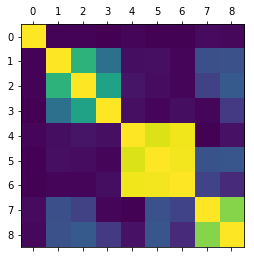

time: 725 ms


In [48]:
corr = features.corr()
plt.matshow(corr.abs())
corr

(1762,)


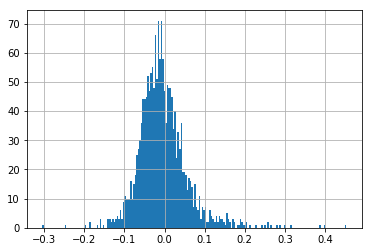

time: 698 ms


In [30]:
vix = ds.load_vix()
rel_dist = vix.vix_close / vix.vix_open - 1
print(rel_dist.shape)
rel_dist.describe()
rel_dist.hist(bins=200)

In [31]:
def get_predictors(n_features, n_timestamps=7, n_classes=3):
    return [
        Heuristic('_v_l1', n_features, n_timestamps, Heuristic.last_vix_movement),
        Heuristic('_l1', n_features, n_timestamps, Heuristic.last_movement),
        Heuristic('_all', n_features, n_timestamps, Heuristic.mean_movement),
        Heuristic('_l3', n_features, n_timestamps, Heuristic.last_three_movements),
    ]
evaluator = Evaluator('heuristics', datasets, get_predictors, '../reports', seed=42, store=False,
                      n_train_samples=300000, n_test_samples=60000)
metrics = evaluator()

2018-12-19 17:19:59 [INFO] src.evaluation.evaluator: ---------- Prepare dataset ----------
2018-12-19 17:20:00 [INFO] src.preparation: Train Labels --> -1.0: 100000; 0.0: 100000; 1.0: 100000
2018-12-19 17:20:00 [INFO] src.preparation: Training range: 2010-01-04 00:00:00 to 2014-06-09 00:00:00
2018-12-19 17:20:00 [INFO] src.preparation: Test Labels --> -1.0: 9973; 0.0: 37661; 1.0: 12366
2018-12-19 17:20:00 [INFO] src.preparation: Testing range: 2016-01-04 00:00:00 to 2016-12-30 00:00:00
2018-12-19 17:20:00 [INFO] src.preparation: Done preparing data
2018-12-19 17:20:00 [INFO] src.evaluation.evaluator: ---------- Heuristic_v_l1 | MvOC-3C ----------
2018-12-19 17:20:01 [INFO] src.evaluation.evaluator: ---------- Heuristic_l1 | MvOC-3C ----------
2018-12-19 17:20:03 [INFO] src.evaluation.evaluator: ---------- Heuristic_all | MvOC-3C ----------
2018-12-19 17:20:05 [INFO] src.evaluation.evaluator: ---------- Heuristic_l3 | MvOC-3C ----------
time: 7.72 s
